In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

### Data preparation

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv"
df = pd.read_csv(data)

In [3]:
df.columns = df.columns.str.lower()

status_values = {1: "ok", 2: "default", 0: "unk"}

df.status = df.status.map(status_values)

home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unk",
}

df.home = df.home.map(home_values)

marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk",
}

df.marital = df.marital.map(marital_values)

records_values = {1: "no", 2: "yes", 0: "unk"}

df.records = df.records.map(records_values)

job_values = {1: "fixed", 2: "partime", 3: "freelance", 4: "others", 0: "unk"}

df.job = df.job.map(job_values)

for c in ["income", "assets", "debt"]:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df = df[df.status != "unk"].reset_index(drop=True)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == "default").astype("int").values
y_test = (df_test.status == "default").astype("int").values

del df_train["status"]
del df_test["status"]

In [5]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient="records")
X_test = dv.transform(test_dicts)

### Random forest

In [6]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [7]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


### XGBoost
Note:
We removed feature names
   
It was <br>
    ```
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    ```

Now it's

`
dtrain = xgb.DMatrix(X_train, label=y_train)
`

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [9]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

## BentoML

### Question 1

* What's the version of BentoML you installed?

### Answer Q1: BentoML version '1.0.7'

In [10]:
import bentoml

bentoml.__version__

'1.0.7'

In [ ]:
bentoml.xgboost.save_model(
    'credit_risk_model',
    model,
    custom_objects={
        'dictVectorizer': dv
    })

In [11]:
modelBML = bentoml.xgboost.save_model(
    'credit_risk_model',
    model,
    custom_objects={
        'dictVectorizer': dv
    })

In [12]:
modelBML.info.to_dict()

{'name': 'credit_risk_model',
 'version': 'aiand7sty2ub7ihh',
 'module': 'bentoml.xgboost',
 'labels': {},
 'options': {'model_class': 'Booster'},
 'metadata': {},
 'context': {'framework_name': 'xgboost',
  'framework_versions': {'xgboost': '1.6.2'},
  'bentoml_version': '1.0.7',
  'python_version': '3.9.12'},
 'signatures': {'predict': {'batchable': False}},
 'api_version': 'v2',
 'creation_time': '2022-10-24T18:02:22.060161+00:00'}

In [13]:
modelBML.validate

<bound method Model.validate of Model(tag="credit_risk_model:aiand7sty2ub7ihh", path="C:\Users\adamf\bentoml\models\credit_risk_model\aiand7sty2ub7ihh\")>

### Question 3

#### Say you have the following data that you're sending to your service:

```json
{
  "name": "Tim",
  "age": 37,
  "country": "US",
  "rating": 3.14
}
```

What would the pydantic class look like? You can name the class `UserProfile`.

#### Answer Q3: 

```python
class UserProfile(BaseModel):
    name : str
    age: int
    country : str
    rating : float
```

In [14]:
!pip install pydantic

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from pydantic import BaseModel

In [16]:
class UserProfile(BaseModel):
    name : str
    age: int
    country : str
    rating : float

In [20]:
# The right test data
userOk = {
  "name": "Tim",
  "age": 37,
  "country": "US",
  "rating": 3.14
}

In [21]:
# Wrong test data
userNOk = {
  "name": 43,
  "age": "How old?",
  "country":  840,
  "rating": 2
}

In [22]:
try:
    print(f"{UserProfile(**userOk)}")
    print(f">>> OK -correct data")
except Exception as err:
    print(f">>> NOT OK \n Wrong data:  {err}")

name='Tim' age=37 country='US' rating=3.14
>>> OK -correct data


In [23]:
try:
    print(f"{UserProfile(**userNOk)}")
    print(f">>> OK ")
except Exception as err:
    print(f">>> NOT OK \n Wrong data: {err}")
    print(f"input the correct data")

>>> NOT OK 
 Wrong data: 1 validation error for UserProfile
age
  value is not a valid integer (type=type_error.integer)
input the correct data


### Question 4

We've prepared a model for you that you can import using:

```bash
curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel.bentomodel
bentoml models import coolmodel.bentomodel
```

What version of scikit-learn was this model trained with?


#### Answer Q4

* 1.1.1


In [24]:
!curl --help

Usage: curl [options...] <url>
 -d, --data <data>          HTTP POST data
 -f, --fail                 Fail silently (no output at all) on HTTP errors
 -h, --help <category>      Get help for commands
 -i, --include              Include protocol response headers in the output
 -o, --output <file>        Write to file instead of stdout
 -O, --remote-name          Write output to a file named as the remote file
 -s, --silent               Silent mode
 -T, --upload-file <file>   Transfer local FILE to destination
 -u, --user <user:password> Server user and password
 -A, --user-agent <name>    Send User-Agent <name> to server
 -v, --verbose              Make the operation more talkative
 -V, --version              Show version number and quit

This is not the full help, this menu is stripped into categories.
Use "--help category" to get an overview of all categories.
For all options use the manual or "--help all".


In [25]:
!curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel.bentomodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1724  100  1724    0     0   1543      0  0:00:01  0:00:01 --:--:--  1544


In [26]:
!bentoml models import coolmodel.bentomodel

Model(tag="mlzoomcamp_homework:qtzdz3slg6mwwdu5") imported


In [27]:
!type C:\Users\adamf\bentoml\models\mlzoomcamp_homework\qtzdz3slg6mwwdu5\model.yaml

name: mlzoomcamp_homework
version: qtzdz3slg6mwwdu5
module: bentoml.sklearn
labels: {}
options: {}
metadata: {}
context:
  framework_name: sklearn
  framework_versions:
    scikit-learn: 1.1.1
  bentoml_version: 1.0.7
  python_version: 3.9.12
signatures:
  predict:
    batchable: false
api_version: v1
creation_time: '2022-10-13T20:42:14.411084+00:00'


In [28]:
!type bentofile.yaml

service: "hw7q5_service.py:svc"
labels:
  owner: AdamFdnb
  project: mlzc
include:
- "*.py"
python:
  packages:
    - xgboost
    - sklearn
    - pydantic
    - numpy
    


base) c:\Users\adamf\Documents\Programing\zoomcamp\07-bentoml-production>bentoml build
** Import completed**
>> Get model <<
>> Run model <<
Building BentoML service "hw7q5_service:2stuqm2sls5quaaa" from build context "C:\Users\adamf\Documents\Programing\zoomcamp\07-bentoml-production"
Packing model "mlzoomcamp_homework:qtzdz3slg6mwwdu5"
Locking PyPI package versions..
C:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

██████╗░███████╗███╗░░██╗████████╗░█████╗░███╗░░░███╗██╗░░░░░
██╔══██╗██╔════╝████╗░██║╚══██╔══╝██╔══██╗████╗░████║██║░░░░░
██████╦╝█████╗░░██╔██╗██║░░░██║░░░██║░░██║██╔████╔██║██║░░░░░
██╔══██╗██╔══╝░░██║╚████║░░░██║░░░██║░░██║██║╚██╔╝██║██║░░░░░
██████╦╝███████╗██║░╚███║░░░██║░░░╚█████╔╝██║░╚═╝░██║███████╗
╚═════╝░╚══════╝╚═╝░░╚══╝░░░╚═╝░░░░╚════╝░╚═╝░░░░░╚═╝╚══════╝

Successfully built Bento(tag="hw7q5_service:2stuqm2sls5quaaa")


bentoml containerize hw7q5_service:2stuqm2sls5quaaa

Building docker image for Bento(tag="hw7q5_service:2stuqm2sls5quaaa")...
Successfully built docker image for "hw7q5_service:2stuqm2sls5quaaa" with tags "hw7q5_service:2stuqm2sls5quaaa"
To run your newly built Bento container, pass "hw7q5_service:2stuqm2sls5quaaa" to "docker run". For example: "docker run -it --rm -p 3000:3000 hw7q5_service:2stuqm2sls5quaaa serve --production"

In [29]:
# download second model
!curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel2.bentomodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1728  100  1728    0     0   1742      0 --:--:-- --:--:-- --:--:--  1743


In [31]:
!bentoml models import coolmodel2.bentomodel

Model(tag="mlzoomcamp_homework:jsi67fslz6txydu5") imported


### test

### Question 6
#### Which model has better performance at higher volumes?

    * The first model
    * The second model
    
#### Answer Q6:
The first model has a higher performance



### Locust Test Model 1

coolmodel.bentomodel

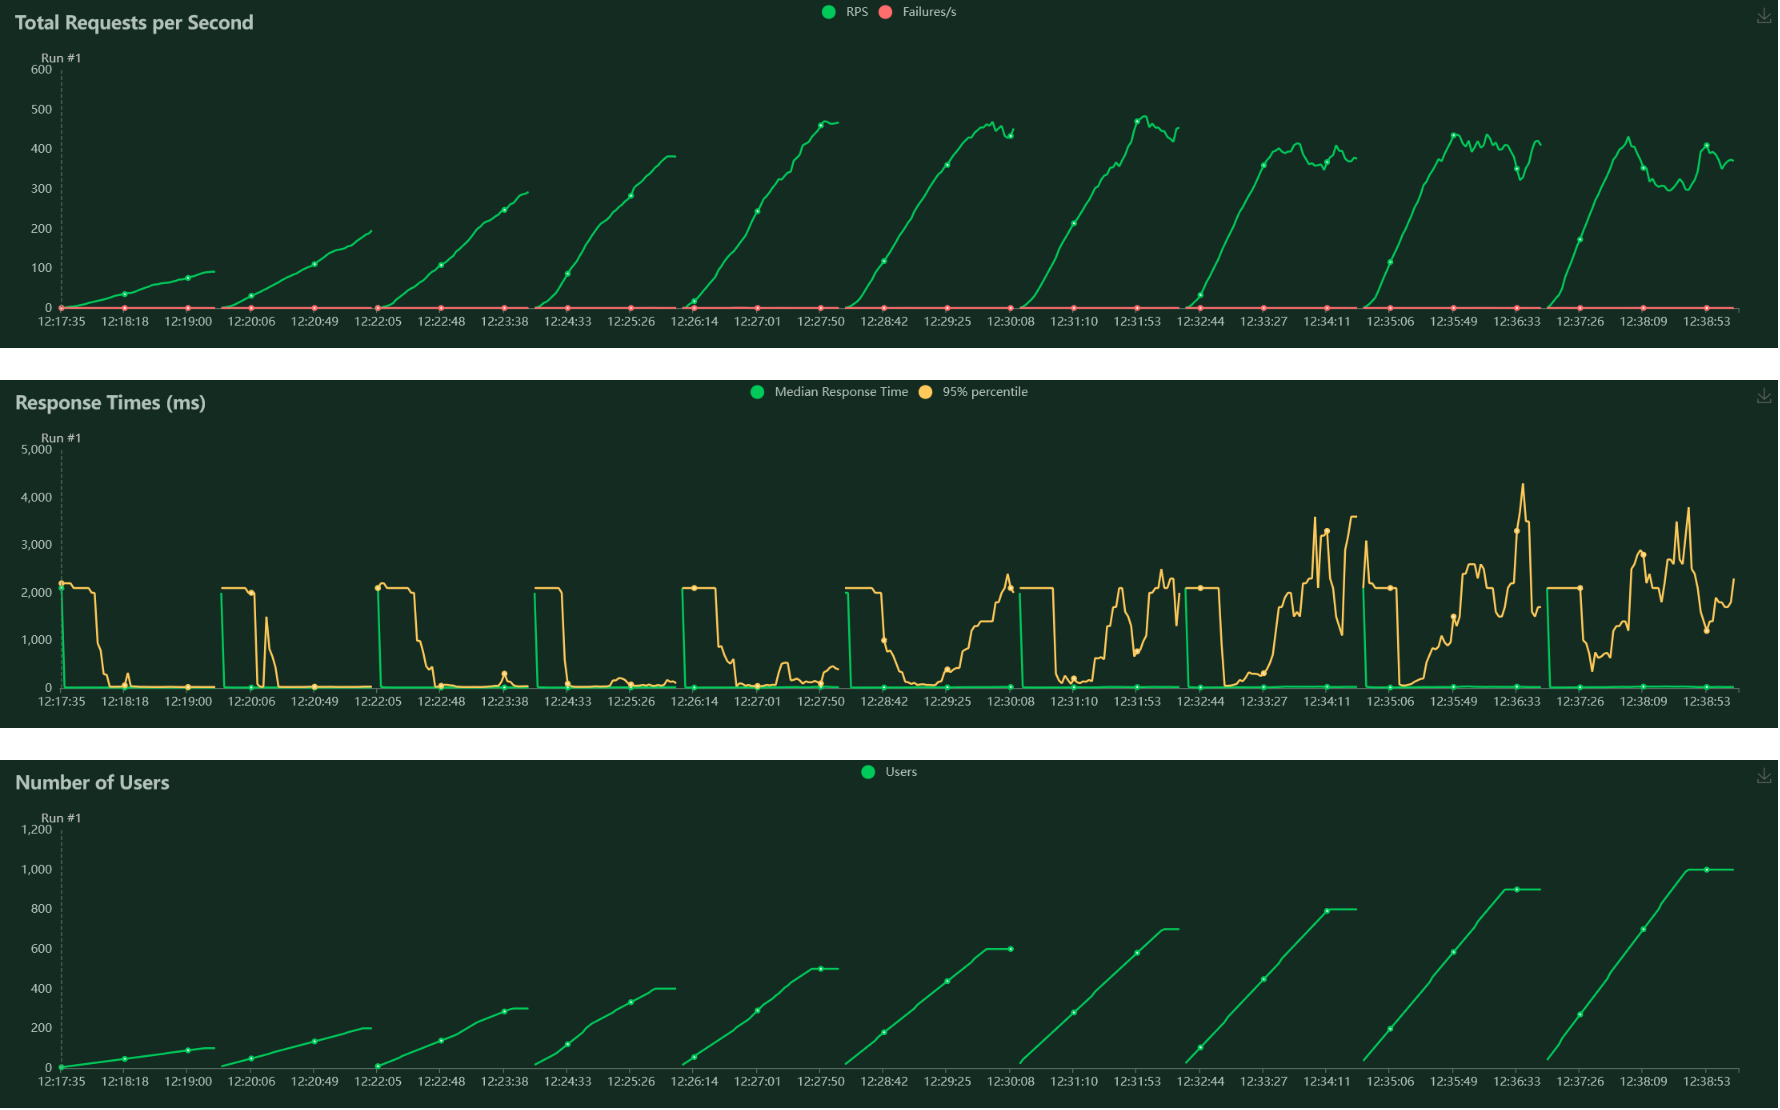

### Locust Test Model 2

coolmodel2.bentomodel

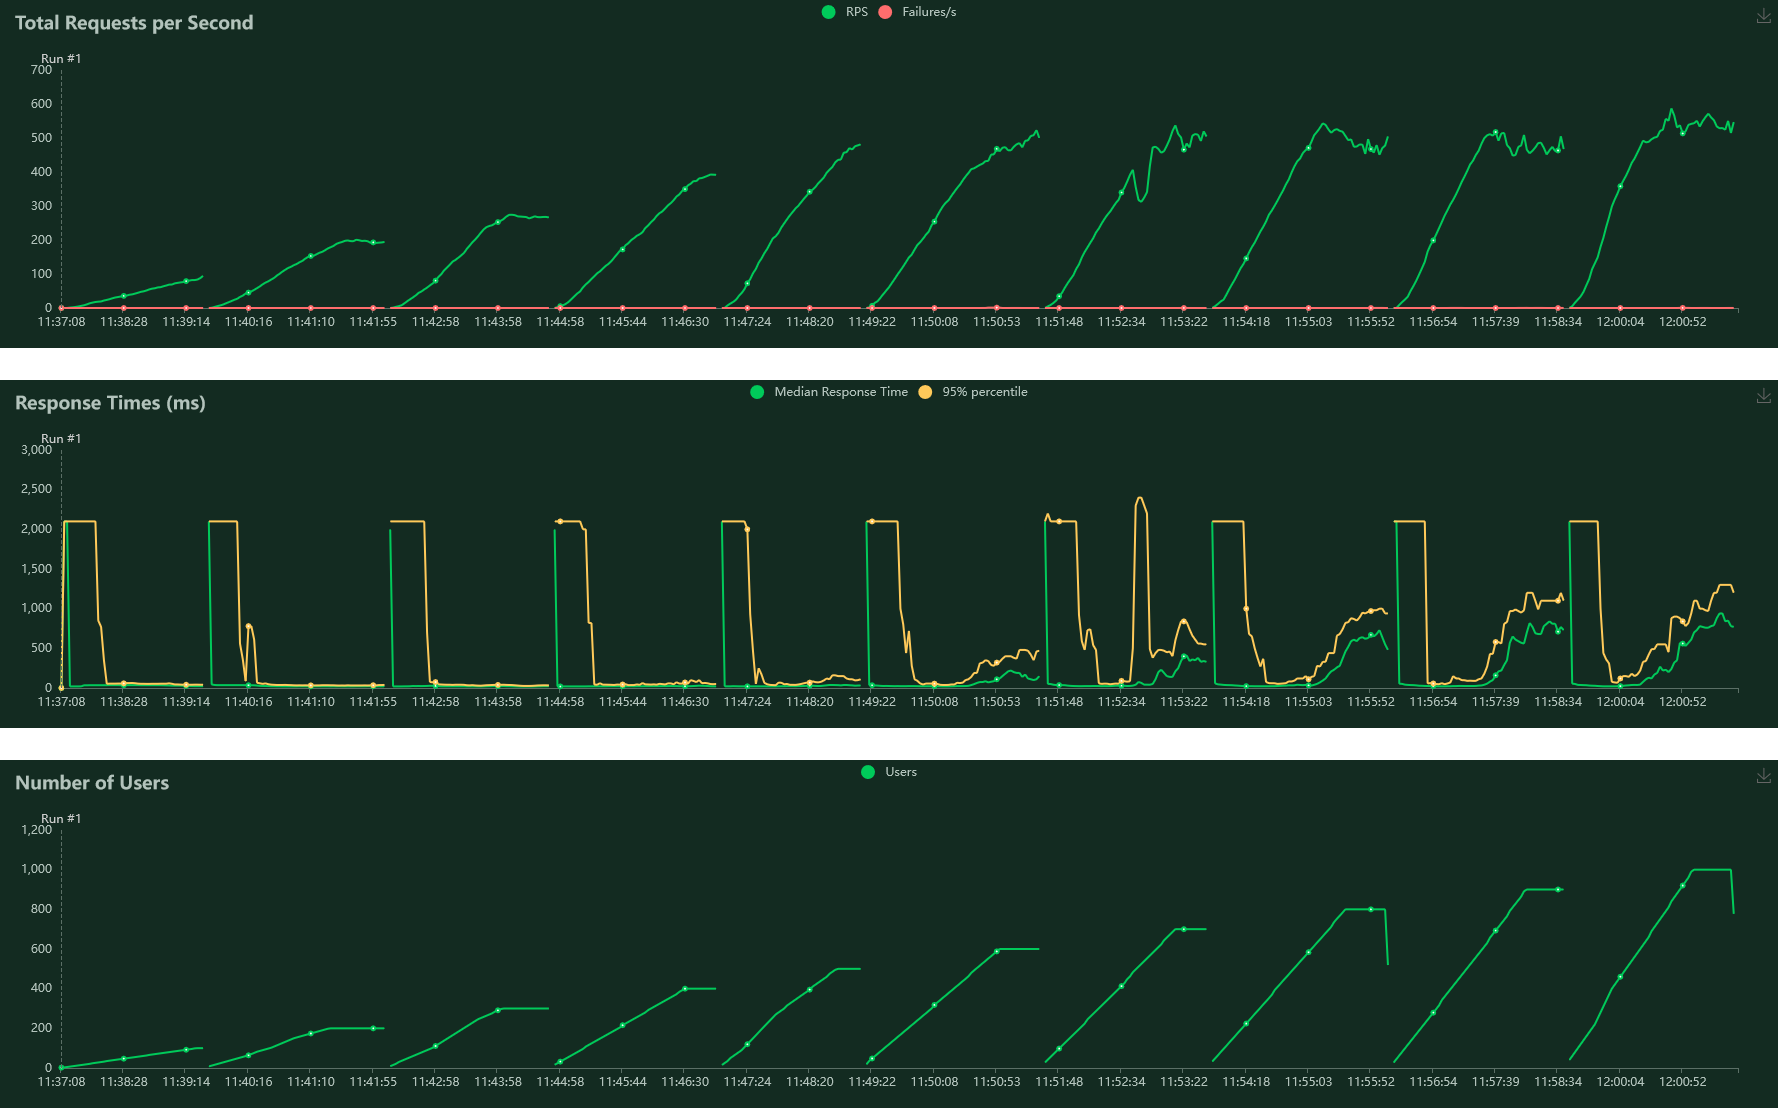

In [32]:
import json

In [33]:
request = df_test.iloc[45].to_dict()
print(json.dumps(request, indent=2))

{
  "seniority": 28,
  "home": "owner",
  "time": 36,
  "age": 46,
  "marital": "married",
  "records": "no",
  "job": "fixed",
  "expenses": 75,
  "income": 170.0,
  "assets": 6000.0,
  "debt": 0.0,
  "amount": 750,
  "price": 800
}
